# Style Transfer: Trabajo Final Alejandro Chaín

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [ ]:
# Imagen para estilo
#!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
#!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
#!mkdir /content/output

In [1]:
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K
from pathlib import Path
import os
from matplotlib import pyplot as plt

import time
from imageio import imwrite

import tensorflow as tf
tf.compat.v1.disable_eager_execution()


In [2]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida
base_image_path = Path("./content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("./content/La_noche_estrellada1.jpg")
result_prefix = Path("./content/output")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta: 
El 'Total Variation Weight' es el hiperparámetro que pondera la sumatoria de la diferencia en términos absolutos de los valores de los pixeles vecinos. Mientras más alto sea este hiperparámetro, mas "suave" será la reconstrucción de la imagen con la transferencia de estilo, es decir, menor ruido tendrá, debido a que intentará que la transición de los valores entre los pixeles que se encuentran cerca sea muy moderada. 

El "Style Weight" es un hiperparámetro que pondera la importancia que tendrán los Features del "estilo" en la reconstrucción de la imagen del output a través de la Loss del modelo. Mientras más alto sea este hiperparámetro, mayor será la influencia de la textura de la "imagen de estilo" en el output del modelo. Por otro lado, el "Content Weight" es un hiperparámetro que pondera la importancia que tendrán los Features del "contenido" en la Loss del modelo de transferencia de estilo. El contenido esta dado por la estructura y la ubicación de los objetos  que son respresentados en la imagen que se utiliza para aplicarle un estilo determinado.

Por ejemplo, si tenemos una pintura de un artista famoso que brinda el estilo y una foto de un perro que brinda el contenido en el modelo, mientras más alta sea la ponderación del "Style Weight" en la Loss, la imagen del "output" será cada vez mas similar a la forma de pintar del artista, pero será cada vez más irreconocible que la imagen se trata de un perro. En cambio, cuando más alto sea el parámetro del "Content Weight" en la Loss, más claro será que se trata de un perro y cada vez se verá menos la influencia del estilo del artista en la imagen del "output"



In [3]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
#Para mantener el Aspect Ratio
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:
La funcionde "preprocess_image" carga una imagen en la primera linea, con una dimesión definida a priori por img_nrows e img_ncols en pixeles.
EN segundo lugar, convierte este objeto que es del tipo "PIL.Image.Image" a un RESPRESENTACIÓN de la imagen en un Numpy Array ,con un shape de (height,width,channels).

La tercer linea convierte este numpy array con shape de (height,width,channels) a uno que contenga el tamaño del batch, el cual es necesario para entrenar
en el modelo con keras, esto es lo que hace la función "expand_dims(x, axis=0)", permite convertir una imagen respresentada en un array con shape (h,w,c) a uno que contenga en primer lugar el tamaño del batch, que en este caso es 1, quedando la imagen (en representación de un array) de la forma (batch_size,height, width,channels).

Por último, la ultima linea antes del return con la función de "vgg19.preprocess_input" permite cambiar los canales de una imagen que esta en formato de "RGB" a una imagen que esta en formato de "BRG", esto princcipalmente porque el entrenamiento de la vgg19 se hizo con imagenes en formato "BRG" y como se esta realizando transfer learning, los parametros pre-entrenados que se van a estar "reutilizando" estan calculados para ser utilizados ocn imagenes con el orden de los canales en "BRG".
Por ultimo, la funcion "vgg19.preprocess_input" también centra los valores de los pixeles de cada una de las imagenes con respecto al valor medio de los pixeles de cada uno de los canales. Esto lo hace sin escalar, es decir, solamente centra los valores restandole la media del valor de los pixeles en cada canal pero NO los escala para que varien , por ejemlo, entre 0 y 1, o -1 y 1.


In [4]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:
La celda con la funcion de "deprocess_image" lo que hace es dar formato al "OutPut" del modelo para que pueda ser visualizada como una imagen "RGB", en donde en primer lugar hace un reshape para que en array quede con una forma de (height,width,channels),  luego  "descentra" los valores de los pixeles de la imagen, realizando el proceso inverso al "preprocess_input" en donde ahora suma la media del valor de los pixeles para cada canal que estàn definidos en https://gist.github.com/ksimonyan/3785162f95cd2d5fee77#file-readme-md y por ultimo invierte los canales de "BGR" a "RGB" ( a través de x[:, :, ::-1]). 

Para finalizar "clipea" la imagen, restringiendo los resultados a los posibles en los que puede variar un pixel, que es en el intervalo cerrado de 0 a 255 para que en el caso de que un resultado este por debajo de 0 quede imputado como 0 y en el caso de que un resultado de un pixel este por encima de 255 este quede imputado como 255. 


In [5]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.constant(preprocess_image(base_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

In [7]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [8]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [9]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


In [10]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(3, 400, 517, 3)]        0         
                                                                 
 block1_conv1 (Conv2D)       (3, 400, 517, 64)         1792      
                                                                 
 block1_conv2 (Conv2D)       (3, 400, 517, 64)         36928     
                                                                 
 block1_pool (MaxPooling2D)  (3, 200, 258, 64)         0         
                                                                 
 block2_conv1 (Conv2D)       (3, 200, 258, 128)        73856     
                                                                 
 block2_conv2 (Conv2D)       (3, 200, 258, 128)        147584    
                                                                 
 block2_pool (MaxPooling2D)  (3, 100, 129, 128)        0     

# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

1) La matriz de Gram o "Gram Matrix" es el resultado del producto punto entre una matriz $A$ y su transupuesta $A^T$. A tavés de este producto punto se puede medir la correlación de los vectores que conforman la matriz, que en este caso son los distintos "features maps" que se extraen de cada capa convolucional reshapeados con un flatten.  Mientras más alto sea el resultado del producto punto entre las matrices, mayor sera la correlación entre las características que detecta la capa convolucional a través de sus diferentes filtros. 

    Siguiendo con un ejemplo, si una capa convolucional en uno de sus filtros detecta las formas geométricas, y en otro detecta los colores, y supongamos que en la imagen tiene muchos soles, en donde la forma geométrica del circulo va a tener una elevada correlación con el color amarillo , en ese caso el producto punto entre esos vectores será igual a un número, el cual si se compara con otra imagen que también tenga soles amarillos poseera una magnitud extremadamente similar, mientras que si se ompara el resultado de la gram matrix con una imagen que tenga un paisaje de noche, probablemente su matriz de gram de como resultado un numero bastante distinto. 

    Cabe aclarar que esto no tiene en cuenta en donde este ubicado el sol, ni tampoco en que parte de la imagen esta pintado de amarrillo, porque esto no tiene en cuenta la espacialidad, es por eso que la matriz de Gram se utiliza para formar la StyleLoss, porque no importa la estructura del contenido, sino el estilo de la imagen.
>   >

2) Se permutan las dimensiones en el cálculo de la Matriz de Gram porque los outputs de los bloques convolucionales que se extraen de la red VGG-19 tienen el shape de (height,width,n_channels) y se los transforma permutando las dimensiones a un shape de (n_channels,height,width). Esto debido a que en el producto punto en la siguiente instancia se busca que el producto entre la matriz de features y la matriz transpuesta de features sea a traves de dos matrices de 2 dimensiones con un shape de n_channels*(width*height), y por eso es necesario que el flatten se haga con una matriz de base que tenga en primer lugar el numero de canales (o de filtros, como se lo quiera decir) y en segundo y tercer lugar el ancho y el alto del feature map.

    Basicamente, el permute_dimensions() permite organizar el tensor del output de la capa convolucional para que luego se pueda hacer el flatten y la matriz de features quede con la forma correcta para poder hacer el Producto punto.

![image.png](gram_matrix.png)
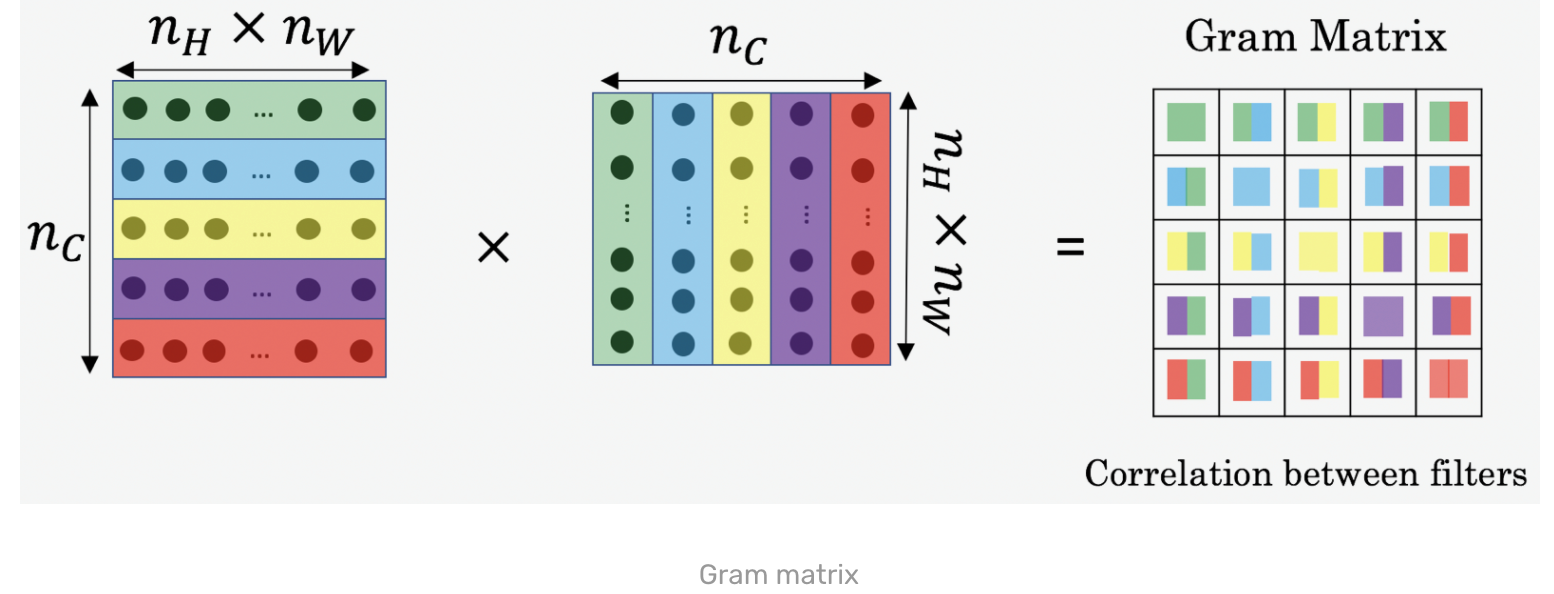

In [11]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:
1) La primer celda contiene la **Style Loss**, esta función de costo esta definida como el la suma de las diferencias al cuadrado entre la matriz de gram de la imagen que define el estilo y de la imagen "combinada" (imagen con el style transfer aplicado).
    
    Siendo que la matriz de gram mide el grado de correlación entre los feature maps de cada una de las capas convolucionales, es de esperar que si los estilos entre las imagenes son similares, las matrices de gram de la imagen del estilo y de la imagen "combinada" sean lo mas parecidas posibles, a tal punto que la suma de sus diferencias al cuadrado esté lo más cercana a cero posible. 

2) La segunda celda contiene la **Content Loss**, esta función de costo esta definida como la suma de las diferencias al cuadrado de los features maps que se extraen de las "ultimas"  capas convolucionales  (La segunda capa del bloque 5 en particular para este caso) de la red, tanto de la imagen que brinda la base del contenido como de la imagen "combinada". Esta Loss, a diferencia de la **Style Loss**, si tiene en cuenta la estructura y la ubicación espacial de la imagen.
    Nuevamente, mientras más se parezca el contenido de la imagen "base" y de la imagen "combinada", más similares seran los valores de los features maps que se extraigan en las capas convolucionales más altas (son las que extraen las estructuras más complejas de la imagen), y, por ende, menor será la suma de las diferencias al cuadrado que se calcula en la Loss de contenico.
    
3) Por último, la **Total Variation Loss** se encarga de calcular la diferencia entre los saltos de los valores de los pixeles que se encuentran abajo y a la derecha de cada uno de los pixeles, es decir, las diferencias entre los valores de los "pixeles vecinos". Esto se realiza para asegurar la consistencia de la imagen y la continuidad espacial en la consutrcción de la "imagen combinada", para asi evitar que el output de la red sea una imagen pixelada y poco definida. Esta función de costo de alguna manera penaliza los cambios muy bruscos entre las regiones de las imagenes actuando como un metodo de regularización que permite obtener como resultado imagenes mas suaves y con menos saltos de valores entre pixeles. 
 

In [12]:
# Armamos la content Loss 
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [14]:
# Armamos la Style Loss
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_ncols * img_nrows
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [15]:
#Armamos la Total Variation Loss
def total_variation_loss(x):
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] -
        x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] -
        x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [31]:

# Definimos el diccinario con el key con el nombre de cada una de las capas y el value igual a la capa de la red a la que corresponde
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Se define el nombre de la capa a la cual se le va a calcular la. COntent loss (en este caso es la 
#capa convolucional 2 del bloque 5) y las capas a la cual se le va a calcular la Style Loss ( en este caso se tienen
# en cuenta más de una capa, para poder capturar el estilo en todas las escalas de los feature maps)
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Se asignan los pesos (ponderadores) que tendran cada una de las partes en la Loss total
total_variation_weight = 0.1
style_weight = 0.5
content_weight = 50

# Se define la Loss total como una variable en el Backend de Keras (que se ira modificando en cada iteracion)

loss = K.variable(0.)

# Se extrae la capa especifica para la content Loss y se calcula para la imagen base de contenido y la imagen
# Combinada
layer_features = outputs_dict[content_layer]
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
# Se suma a la variable de la Loss la content loss calculada (ponderada por el peso del content loss)
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

## Se hace algo similar pero con todas las capas en la que se va a calcular la Style Loss, para luego sumarlas
## a la total Loss ponderada por el peso del ponderador del estilo reescalado por la cantidad de capas que se consideran
## para el calculo
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl

#Por ultimo se le suma a la total loss el total variation loss ponderado por el peso
loss = loss+ total_variation_weight * total_variation_loss(combination_image)

## Se define el gradiente
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

- La función **fmin_l_bfgs_b** es la encargada de realizar la optimización sobre la imagen base para poder generar la "imagen combinada" que minimice la funcion de costos que contiene la *Style Loss*, la *Content Loss* y la *Total Variation Loss*.

    La implementación  en el Paper dice utilizar Gradient Descent para realizar esta optimización, otra de las opciones de optimizadores que se podrían utilizar son los conocidos como SGD, Adam, entre otros. Sin embargo, en la mayoría de las aplicaciones de Neural Style Transfer se utliza el algoritmo de **l_bfgs_b** debido a que es el que mejor funciona para estos casos, por ejemplo es utilizado en la aplicación del libro de *"Deep Learning with Python" de Francois Chollet* y existe una discusión de cual es el mejor optimizador en este hilo https://www.quora.com/What-is-an-intuitive-explanation-of-BFGS-and-limited-memory-BFGS-optimization-algorithms.

In [32]:
class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_nrows, img_ncols, 3))
        outs = fetch_loss_and_grads([x])
    
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator = Evaluator()

result_prefix = './content/output_more_content/more_content'
iterations = 10
x = preprocess_image(base_image_path)
x = x.flatten()

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [33]:

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    
    
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_nrows, img_ncols, 3))  
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imwrite(fname, img)
    print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 8106422000.0
Image saved as ./content/output_more_content/more_content_at_iteration_0.png
Iteration 0 completed in 200s
Start of iteration 1
Current loss value: 5758779400.0
Image saved as ./content/output_more_content/more_content_at_iteration_1.png
Iteration 1 completed in 179s
Start of iteration 2
Current loss value: 4709424000.0
Image saved as ./content/output_more_content/more_content_at_iteration_2.png
Iteration 2 completed in 176s
Start of iteration 3
Current loss value: 4150504400.0
Image saved as ./content/output_more_content/more_content_at_iteration_3.png
Iteration 3 completed in 187s
Start of iteration 4
Current loss value: 3760235500.0
Image saved as ./content/output_more_content/more_content_at_iteration_4.png
Iteration 4 completed in 193s
Start of iteration 5
Current loss value: 3482968800.0
Image saved as ./content/output_more_content/more_content_at_iteration_5.png
Iteration 5 completed in 169s
Start of iteration 6
Current loss 

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:

1. La primer imágen generada luego de 20 iteraciones con los pesos de las losses en **"Style Weight"==10 & Content_Weight==1 & Total_variation_weight==0.1"** es igual a :
<br> <br/>
<img src="https://github.com/alechain/style_transfer_chain_alejandro/raw/f86fb9ec5c7cd7f45ce83efd5c76d3be486d2d1d/content/output/my_result_at_iteration_19.png" >
<br> <br/>
En esta imágen se puede diferenciar facilmente el contenido de la imagen de la ciudad de Tubingen y el estilo del cuadro de la noche estrellada, con una imágen que se ve bastante suave (gracias a la Loss del Total variation).
<br> <br/>
2. A continuación, se ve una imágen generada a través de 10 iteraciones en donde se pondera con mayor peso la transferencia del estilo y no tanto la de contenido, con un **"Style Weight"==100 &  Content_Weight==0.5 & Total_variation_weight==0.1"**
<br> <br/>
<img src="https://github.com/alechain/style_transfer_chain_alejandro/raw/main/content/output_more_style/more_style_at_iteration_9.png" >
<br> <br/>
En comparación con la primer imágen, en donde los pesos de los ponderadores de la loss de estilo y de contenido están más "balanceados", en esta se puede ver como la imágen generada es cáda vez más similar al cuadro de la noche estrellada mientras que el contenido de la foto se  empieza a deformar, perdiendo las lineas definidas de las casas y convirtiendo a los arboles en espirales. Tambien los bordes del rio comienzan a desbordar el puente, y es más complicado ver la Ciudad de Tubingen con tanta claridad. Sin embargo, el estilo de la noche estrellada está mucho más presente.
<br> <br/>

3. En esta imágen  generada a través de 10 iteraciones, se pondera con mayor peso la transferencia del contenido y no tanto la de estilo, con un **"Style Weight"==5 &  Content_Weight==30 & Total_variation_weight==0.1"**
<br> <br/>
<img src="https://github.com/alechain/style_transfer_chain_alejandro/raw/main/content/output_more_style/more_style_at_iteration_9.png">
<br> <br/>
En comparación con la primer imágen,  en esta se puede ver como la imágen generada es cáda vez más similar al cuadro de la noche estrellada mientras que el contenido de la foto se  empieza a deformar, perdiendo las lineas definidas de las casas y convirtiendo a los arboles en espirales. Tambien los bordes del rio comienzan a desbordar el puente, y es más complicado ver la Ciudad de Tubingen con tanta claridad. Sin embargo, el estilo de la noche estrellada está mucho más presente.

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta: